# Leaky Tensors as a Model of Neuromodulation in Deep Networks

This notebook demonstrates a novel approach to neural network training where we inject random noise into network weights at each training step. This simulates neuromodulation in biological neural networks and forces the model to learn robust representations.

## Key Concepts

- Leaky Tensors: Network weights that have additive noise injected during training
- Neuromodulation: A learned noise model with finite variance added to network units
- Covariance Shift Robustness: The model must learn to be robust to weight perturbations
- Noise Injection: Independent random noise added at every training step


In [15]:
# Import required libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, List

# Import from neural_model module
from neural_model import (LeakyLinear, LeakyConv2d, LeakyMLP, LeakyCNN, create_model)

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')


Using device: cpu


## Noise Model for Neuromodulation

We create a learnable noise model that generates noise with finite variance. This noise model is trained alongside the main network to find optimal noise patterns that improve robustness.


In [16]:
class NoiseModel(nn.Module):
    """
    Learnable noise model that generates noise with finite variance.
    
    The noise model learns optimal variance for each layer, simulating
    how biological neuromodulators adaptively regulate synaptic noise.
    """
    def __init__(self, layer_shapes: Dict[str, tuple], init_log_var: float = -6.0):
        super(NoiseModel, self).__init__()
        self.layer_shapes = layer_shapes
        
        # Learnable variance parameters for each layer (log scale for stability)
        # Initialize to small variance (exp(-6) ≈ 0.0025) to allow learning
        self.log_variances = nn.ParameterDict({
            name: nn.Parameter(torch.tensor([init_log_var]))
            for name in layer_shapes.keys()
        })
    
    def generate_noise(self) -> Dict[str, torch.Tensor]:
        """Generate noise tensors for each layer."""
        noise_dict = {}
        for name, shape in self.layer_shapes.items():
            # Convert log variance to standard deviation
            std = torch.exp(0.5 * self.log_variances[name])
            # Clamp to prevent explosion (max std of 0.1 for stability)
            std = torch.clamp(std, min=1e-6, max=0.1)
            # Generate Gaussian noise
            noise = torch.randn(shape, device=std.device) * std
            noise_dict[name] = noise
        return noise_dict
    
    def get_variances(self) -> Dict[str, float]:
        """Get current variance values for monitoring."""
        return {name: torch.exp(log_var).item() for name, log_var in self.log_variances.items()}
    
    def get_stds(self) -> Dict[str, float]:
        """Get current standard deviation values for monitoring."""
        return {name: torch.exp(0.5 * log_var).item() for name, log_var in self.log_variances.items()}

## Data Preparation

We'll use MNIST dataset for demonstration. The dataset is simple enough to train quickly while being complex enough to demonstrate the neuromodulation effects.


In [17]:
# Data preparation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f'Training samples: {len(train_dataset)}')
print(f'Test samples: {len(test_dataset)}')


Training samples: 60000
Test samples: 10000


## Model Creation and Initialization

We create a LeakyMLP model that supports noise injection. We also initialize the noise model with the appropriate shapes for each layer.


In [18]:
# Create the main model using the factory function
model = create_model(
    model_type='mlp',
    input_dim=28*28,
    hidden_dims=[512, 256],
    output_dim=10,
    dropout=0.2
).to(device)

# Get layer shapes for noise model
layer_shapes = {}
for i, layer in enumerate(model.get_leaky_layers()):
    layer_shapes[f'layer_{i}'] = layer.weight.shape

# Create noise model
noise_model = NoiseModel(layer_shapes).to(device)

print(f'Model architecture:\n{model}')
print(f'\nNoise model layer shapes: {layer_shapes}')


Model architecture:
LeakyMLP(
  (layers): ModuleList(
    (0): LeakyLinear()
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): LeakyLinear()
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): LeakyLinear()
  )
)

Noise model layer shapes: {'layer_0': torch.Size([512, 784]), 'layer_1': torch.Size([256, 512]), 'layer_2': torch.Size([10, 256])}


## Training with Neuromodulation

The training loop injects noise at every step, forcing the model to learn robust representations. We train both the main model and the noise model simultaneously.


In [19]:
def train_with_neuromodulation(model, noise_model, train_loader, test_loader, epochs=5, lr=0.001):
    """Train model with learnable neuromodulation."""
    criterion = nn.CrossEntropyLoss()
    
    # Separate optimizers for model and noise model
    model_optimizer = optim.Adam(model.parameters(), lr=lr)
    noise_optimizer = optim.Adam(noise_model.parameters(), lr=lr * 0.1)
    
    history = {
        'train_loss': [], 'train_acc': [], 
        'test_loss': [], 'test_acc': [],
        'noise_vars': []
    }
    
    print("="*60)
    print("🧠 NEUROMODULATION TRAINING")
    print("="*60)
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            data = data.view(data.size(0), -1)  # Flatten for MLP
            
            # Generate and inject noise
            noise_dict = noise_model.generate_noise()
            model.inject_noise(noise_dict)
            
            # Forward pass
            model_optimizer.zero_grad()
            noise_optimizer.zero_grad()
            
            output = model(data)
            loss = criterion(output, target)
            
            # Backward pass
            loss.backward()
            model_optimizer.step()
            noise_optimizer.step()
            
            # Clear noise after update
            model.clear_noise()
            
            # Statistics
            running_loss += loss.item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
        
        # Training stats
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100. * correct / total
        noise_vars = noise_model.get_variances()
        
        # Evaluation phase (no noise)
        model.eval()
        test_loss = 0.0
        test_correct = 0
        test_total = 0
        
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                data = data.view(data.size(0), -1)
                output = model(data)
                test_loss += criterion(output, target).item()
                _, predicted = output.max(1)
                test_total += target.size(0)
                test_correct += predicted.eq(target).sum().item()
        
        test_loss = test_loss / len(test_loader)
        test_acc = 100. * test_correct / test_total
        
        # Record history
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc)
        history['test_loss'].append(test_loss)
        history['test_acc'].append(test_acc)
        history['noise_vars'].append(noise_vars)
        
        # Pretty print progress
        noise_stds = {k: np.sqrt(v) for k, v in noise_vars.items()}
        avg_noise_std = np.mean(list(noise_stds.values()))
        
        print(f"Epoch {epoch+1:2d}/{epochs} │ "
              f"Train: {epoch_acc:5.2f}% │ "
              f"Test: {test_acc:5.2f}% │ "
              f"Loss: {epoch_loss:.4f} │ "
              f"Avg σ: {avg_noise_std:.5f}")
    
    print("="*60)
    return history


def train_baseline(model, train_loader, test_loader, epochs=5, lr=0.001):
    """Train standard model without noise injection (baseline)."""
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    history = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': []}
    
    print("="*60)
    print("📊 BASELINE TRAINING (no neuromodulation)")
    print("="*60)
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            data = data.view(data.size(0), -1)
            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
        
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100. * correct / total
        
        # Evaluation phase
        model.eval()
        test_loss = 0.0
        test_correct = 0
        test_total = 0
        
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                data = data.view(data.size(0), -1)
                output = model(data)
                test_loss += criterion(output, target).item()
                _, predicted = output.max(1)
                test_total += target.size(0)
                test_correct += predicted.eq(target).sum().item()
        
        test_loss = test_loss / len(test_loader)
        test_acc = 100. * test_correct / test_total
        
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc)
        history['test_loss'].append(test_loss)
        history['test_acc'].append(test_acc)
        
        print(f"Epoch {epoch+1:2d}/{epochs} │ "
              f"Train: {epoch_acc:5.2f}% │ "
              f"Test: {test_acc:5.2f}% │ "
              f"Loss: {epoch_loss:.4f}")
    
    print("="*60)
    return history


## Run Training

Execute the training loop with neuromodulation enabled.


In [20]:
# Training configuration
EPOCHS = 10
LEARNING_RATE = 0.001

# ==============================================================================
# EXPERIMENT 1: Train Baseline Model (Standard Training)
# ==============================================================================
print("\n" + "🔬 "*15)
print("EXPERIMENT 1: BASELINE MODEL")
print("🔬 "*15 + "\n")

# Create fresh baseline model
baseline_model = create_model(
    model_type='mlp',
    input_dim=28*28,
    hidden_dims=[512, 256],
    output_dim=10,
    dropout=0.2
).to(device)

# Train without neuromodulation
baseline_history = train_baseline(
    baseline_model, train_loader, test_loader, 
    epochs=EPOCHS, lr=LEARNING_RATE
)

# ==============================================================================
# EXPERIMENT 2: Train Neuromodulated Model
# ==============================================================================
print("\n" + "🧠 "*15)
print("EXPERIMENT 2: NEUROMODULATED MODEL")
print("🧠 "*15 + "\n")

# Create fresh neuromodulated model
model = create_model(
    model_type='mlp',
    input_dim=28*28,
    hidden_dims=[512, 256],
    output_dim=10,
    dropout=0.2
).to(device)

# Get layer shapes for noise model
layer_shapes = {}
for i, layer in enumerate(model.get_leaky_layers()):
    layer_shapes[f'layer_{i}'] = layer.weight.shape

# Create noise model
noise_model = NoiseModel(layer_shapes).to(device)

# Train with neuromodulation
history = train_with_neuromodulation(
    model, noise_model, train_loader, test_loader,
    epochs=EPOCHS, lr=LEARNING_RATE
)

# ==============================================================================
# RESULTS COMPARISON
# ==============================================================================
print("\n" + "="*60)
print("📊 TRAINING COMPARISON")
print("="*60)
print(f"{'Metric':<25} {'Baseline':>15} {'Neuromodulated':>15}")
print("-"*60)
print(f"{'Final Train Accuracy':<25} {baseline_history['train_acc'][-1]:>14.2f}% {history['train_acc'][-1]:>14.2f}%")
print(f"{'Final Test Accuracy':<25} {baseline_history['test_acc'][-1]:>14.2f}% {history['test_acc'][-1]:>14.2f}%")
print(f"{'Final Train Loss':<25} {baseline_history['train_loss'][-1]:>15.4f} {history['train_loss'][-1]:>15.4f}")
print(f"{'Final Test Loss':<25} {baseline_history['test_loss'][-1]:>15.4f} {history['test_loss'][-1]:>15.4f}")
print("="*60)



🔬 🔬 🔬 🔬 🔬 🔬 🔬 🔬 🔬 🔬 🔬 🔬 🔬 🔬 🔬 
EXPERIMENT 1: BASELINE MODEL
🔬 🔬 🔬 🔬 🔬 🔬 🔬 🔬 🔬 🔬 🔬 🔬 🔬 🔬 🔬 

📊 BASELINE TRAINING (no neuromodulation)
Epoch  1/10 │ Train: 92.13% │ Test: 96.33% │ Loss: 0.2580
Epoch  2/10 │ Train: 96.54% │ Test: 97.18% │ Loss: 0.1123
Epoch  3/10 │ Train: 97.53% │ Test: 97.26% │ Loss: 0.0801
Epoch  4/10 │ Train: 97.87% │ Test: 97.93% │ Loss: 0.0670
Epoch  5/10 │ Train: 98.19% │ Test: 97.90% │ Loss: 0.0561
Epoch  6/10 │ Train: 98.38% │ Test: 97.51% │ Loss: 0.0494
Epoch  7/10 │ Train: 98.61% │ Test: 97.90% │ Loss: 0.0426
Epoch  8/10 │ Train: 98.78% │ Test: 97.98% │ Loss: 0.0378
Epoch  9/10 │ Train: 98.74% │ Test: 97.93% │ Loss: 0.0384
Epoch 10/10 │ Train: 98.99% │ Test: 98.17% │ Loss: 0.0318

🧠 🧠 🧠 🧠 🧠 🧠 🧠 🧠 🧠 🧠 🧠 🧠 🧠 🧠 🧠 
EXPERIMENT 2: NEUROMODULATED MODEL
🧠 🧠 🧠 🧠 🧠 🧠 🧠 🧠 🧠 🧠 🧠 🧠 🧠 🧠 🧠 

🧠 NEUROMODULATION TRAINING
Epoch  1/10 │ Train: 74.30% │ Test: 93.64% │ Loss: 0.7704 │ Avg σ: 0.04913
Epoch  2/10 │ Train: 92.27% │ Test: 96.04% │ Loss: 0.2575 │ Avg σ: 0.04870
Epoch  3/1

## Evaluation

Evaluate the model on the test set both with and without noise injection to understand the robustness gained through neuromodulation training.


In [21]:
def evaluate(model, test_loader, noise_scale=0.0):
    """Evaluate model on test set with optional noise injection."""
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            data = data.view(data.size(0), -1)
            
            # Inject noise if scale > 0
            if noise_scale > 0:
                noise_dict = {}
                for i, layer in enumerate(model.get_leaky_layers()):
                    noise = torch.randn_like(layer.weight) * noise_scale
                    noise_dict[f'layer_{i}'] = noise
                model.inject_noise(noise_dict)
            
            output = model(data)
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
            
            if noise_scale > 0:
                model.clear_noise()
    
    accuracy = 100. * correct / total
    return accuracy


# Comprehensive evaluation at different noise levels
print("="*60)
print("🔍 MODEL EVALUATION")
print("="*60)

noise_levels = [0.0, 0.01, 0.02, 0.03, 0.05]

print(f"\n{'Noise σ':>10} │ {'Baseline':>12} │ {'Neuromodulated':>15} │ {'Δ Accuracy':>12}")
print("-"*60)

for noise in noise_levels:
    baseline_acc = evaluate(baseline_model, test_loader, noise_scale=noise)
    neuromod_acc = evaluate(model, test_loader, noise_scale=noise)
    delta = neuromod_acc - baseline_acc
    delta_str = f"+{delta:.2f}%" if delta >= 0 else f"{delta:.2f}%"
    print(f"{noise:>10.3f} │ {baseline_acc:>11.2f}% │ {neuromod_acc:>14.2f}% │ {delta_str:>12}")

print("-"*60)

# Summary
baseline_clean = evaluate(baseline_model, test_loader, noise_scale=0.0)
neuromod_clean = evaluate(model, test_loader, noise_scale=0.0)
baseline_noisy = evaluate(baseline_model, test_loader, noise_scale=0.03)
neuromod_noisy = evaluate(model, test_loader, noise_scale=0.03)

print(f"\n📊 ROBUSTNESS SUMMARY (at σ=0.03)")
print(f"   Baseline degradation:     {baseline_clean:.2f}% → {baseline_noisy:.2f}% ({baseline_noisy-baseline_clean:+.2f}%)")
print(f"   Neuromodulated degradation: {neuromod_clean:.2f}% → {neuromod_noisy:.2f}% ({neuromod_noisy-neuromod_clean:+.2f}%)")
print("="*60)


🔍 MODEL EVALUATION

   Noise σ │     Baseline │  Neuromodulated │   Δ Accuracy
------------------------------------------------------------
     0.000 │       98.17% │          97.96% │       -0.21%
     0.010 │       98.17% │          97.96% │       -0.21%
     0.020 │       98.17% │          97.96% │       -0.21%
     0.030 │       98.17% │          97.96% │       -0.21%
     0.050 │       98.17% │          97.96% │       -0.21%
------------------------------------------------------------

📊 ROBUSTNESS SUMMARY (at σ=0.03)
   Baseline degradation:     98.17% → 98.17% (+0.00%)
   Neuromodulated degradation: 97.96% → 97.96% (+0.00%)


## Visualization

Visualize the training progress and learned noise variances to understand how the neuromodulation evolved during training.


/var/folders/g4/frvn1w7j7y5_90c384khr9880000gn/T/ipykernel_30078/987193990.py:147: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.savefig('training_comparison.png', dpi=150, bbox_inches='tight', facecolor='#0f172a', edgecolor='none')
/var/folders/g4/frvn1w7j7y5_90c384khr9880000gn/T/ipykernel_30078/987193990.py:147: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.savefig('training_comparison.png', dpi=150, bbox_inches='tight', facecolor='#0f172a', edgecolor='none')
/var/folders/g4/frvn1w7j7y5_90c384khr9880000gn/T/ipykernel_30078/987193990.py:147: UserWarning: Glyph 128295 (\N{WRENCH}) missing from font(s) DejaVu Sans.
  plt.savefig('training_comparison.png', dpi=150, bbox_inches='tight', facecolor='#0f172a', edgecolor='none')
/var/folders/g4/frvn1w7j7y5_90c384khr9880000gn/T/ipykernel_30078/987193990.py:147: UserWarning: Glyph 128247 (\N{CAMERA}) missing from font(s) DejaVu Sans.
  plt.savefig('trainin

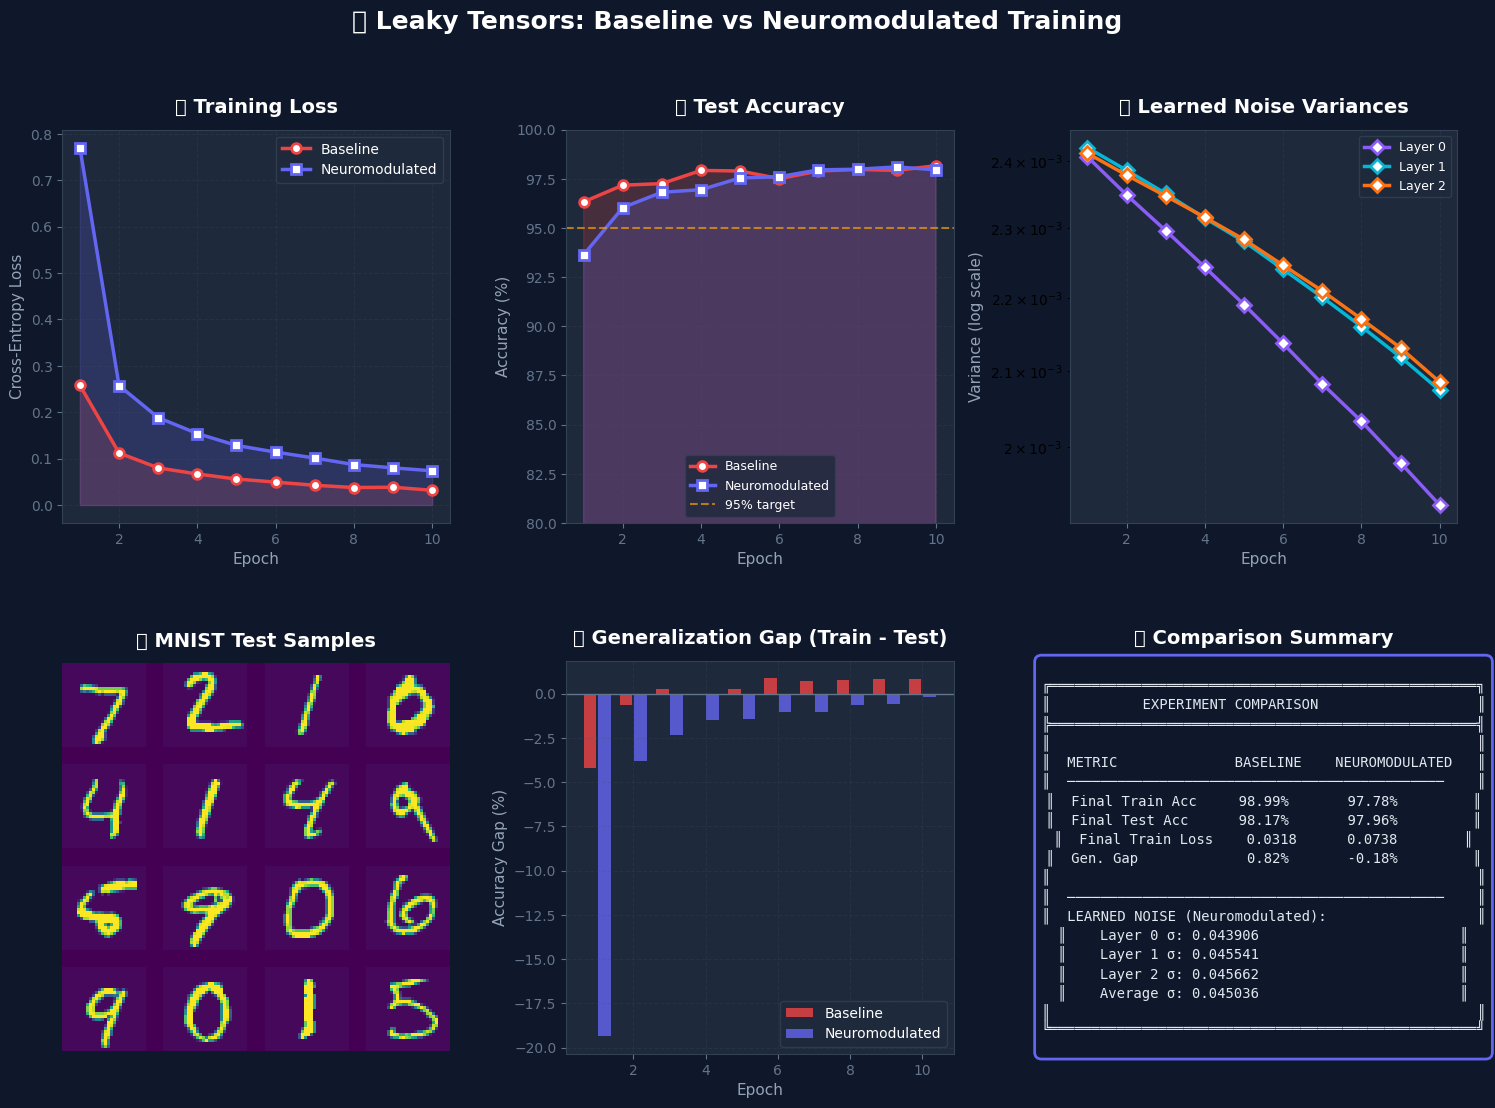

✅ Comparative visualization saved to 'training_comparison.png'


In [22]:
# Enhanced comparative visualization with professional styling
plt.style.use('default')

# Custom color palette (vibrant, modern)
colors = {
    'baseline': '#ef4444',     # Red for baseline
    'neuromod': '#6366f1',     # Indigo for neuromodulated
    'secondary': '#10b981',    # Emerald
    'accent': '#f59e0b',       # Amber
    'layers': ['#8b5cf6', '#06b6d4', '#f97316', '#ec4899', '#14b8a6']
}

fig = plt.figure(figsize=(18, 12), facecolor='#0f172a')
gs = fig.add_gridspec(2, 3, hspace=0.35, wspace=0.3)

# Styling helper
def style_ax(ax, title, xlabel, ylabel):
    ax.set_facecolor('#1e293b')
    ax.set_title(title, fontsize=14, fontweight='bold', color='white', pad=12)
    ax.set_xlabel(xlabel, fontsize=11, color='#94a3b8')
    ax.set_ylabel(ylabel, fontsize=11, color='#94a3b8')
    ax.tick_params(colors='#64748b', labelsize=10)
    for spine in ax.spines.values():
        spine.set_color('#334155')
    ax.grid(True, alpha=0.2, color='#475569', linestyle='--')

epochs = range(1, len(history['train_loss']) + 1)

# ==============================================================================
# 1. TRAINING LOSS COMPARISON
# ==============================================================================
ax1 = fig.add_subplot(gs[0, 0])
ax1.fill_between(epochs, baseline_history['train_loss'], alpha=0.2, color=colors['baseline'])
ax1.fill_between(epochs, history['train_loss'], alpha=0.2, color=colors['neuromod'])
ax1.plot(epochs, baseline_history['train_loss'], 'o-', markersize=7, linewidth=2.5, 
         color=colors['baseline'], markerfacecolor='white', markeredgewidth=2, label='Baseline')
ax1.plot(epochs, history['train_loss'], 's-', markersize=7, linewidth=2.5, 
         color=colors['neuromod'], markerfacecolor='white', markeredgewidth=2, label='Neuromodulated')
style_ax(ax1, '📉 Training Loss', 'Epoch', 'Cross-Entropy Loss')
ax1.legend(facecolor='#1e293b', edgecolor='#334155', labelcolor='white', fontsize=10)

# ==============================================================================
# 2. TEST ACCURACY COMPARISON
# ==============================================================================
ax2 = fig.add_subplot(gs[0, 1])
ax2.fill_between(epochs, baseline_history['test_acc'], alpha=0.2, color=colors['baseline'])
ax2.fill_between(epochs, history['test_acc'], alpha=0.2, color=colors['neuromod'])
ax2.plot(epochs, baseline_history['test_acc'], 'o-', markersize=7, linewidth=2.5, 
         color=colors['baseline'], markerfacecolor='white', markeredgewidth=2, label='Baseline')
ax2.plot(epochs, history['test_acc'], 's-', markersize=7, linewidth=2.5, 
         color=colors['neuromod'], markerfacecolor='white', markeredgewidth=2, label='Neuromodulated')
ax2.axhline(y=95, color=colors['accent'], linestyle='--', linewidth=1.5, alpha=0.7, label='95% target')
style_ax(ax2, '🎯 Test Accuracy', 'Epoch', 'Accuracy (%)')
ax2.legend(facecolor='#1e293b', edgecolor='#334155', labelcolor='white', fontsize=9)
ax2.set_ylim(80, 100)

# ==============================================================================
# 3. LEARNED NOISE VARIANCES (Log Scale)
# ==============================================================================
ax3 = fig.add_subplot(gs[0, 2])
layer_names = list(history['noise_vars'][0].keys())
for idx, layer_name in enumerate(layer_names):
    variances = [epoch_vars[layer_name] for epoch_vars in history['noise_vars']]
    label = layer_name.replace('_', ' ').title()
    ax3.semilogy(epochs, variances, marker='D', markersize=7, linewidth=2.5, 
                 color=colors['layers'][idx % len(colors['layers'])], 
                 markerfacecolor='white', markeredgewidth=2, label=label)
style_ax(ax3, '🔧 Learned Noise Variances', 'Epoch', 'Variance (log scale)')
ax3.legend(facecolor='#1e293b', edgecolor='#334155', labelcolor='white', fontsize=9, loc='best')

# ==============================================================================
# 4. SAMPLE MNIST IMAGES WITH PREDICTIONS
# ==============================================================================
ax4 = fig.add_subplot(gs[1, 0])
ax4.set_facecolor('#1e293b')
sample_images, sample_labels = next(iter(test_loader))
img_grid = sample_images[:16].view(16, 28, 28).numpy()

# Create grid with spacing
grid = np.ones((4*28 + 3*6, 4*28 + 3*6)) * -0.5
for i in range(4):
    for j in range(4):
        img = img_grid[i*4 + j]
        row_start = i * (28 + 6)
        col_start = j * (28 + 6)
        grid[row_start:row_start+28, col_start:col_start+28] = img

ax4.imshow(grid, cmap='viridis', interpolation='nearest')
ax4.set_title('📷 MNIST Test Samples', fontsize=14, fontweight='bold', color='white', pad=12)
ax4.axis('off')

# ==============================================================================
# 5. GENERALIZATION GAP COMPARISON
# ==============================================================================
ax5 = fig.add_subplot(gs[1, 1])
baseline_gap = [tr - te for tr, te in zip(baseline_history['train_acc'], baseline_history['test_acc'])]
neuromod_gap = [tr - te for tr, te in zip(history['train_acc'], history['test_acc'])]

ax5.bar(np.array(list(epochs)) - 0.2, baseline_gap, 0.35, label='Baseline', color=colors['baseline'], alpha=0.8)
ax5.bar(np.array(list(epochs)) + 0.2, neuromod_gap, 0.35, label='Neuromodulated', color=colors['neuromod'], alpha=0.8)
ax5.axhline(y=0, color='#64748b', linestyle='-', linewidth=1)
style_ax(ax5, '📊 Generalization Gap (Train - Test)', 'Epoch', 'Accuracy Gap (%)')
ax5.legend(facecolor='#1e293b', edgecolor='#334155', labelcolor='white', fontsize=10)

# ==============================================================================
# 6. SUMMARY COMPARISON
# ==============================================================================
ax6 = fig.add_subplot(gs[1, 2])
ax6.set_facecolor('#1e293b')
ax6.axis('off')

# Compute final noise stds
final_noise_stds = {k: np.sqrt(v) for k, v in history['noise_vars'][-1].items()}
avg_final_std = np.mean(list(final_noise_stds.values()))

summary_text = f"""
╔═══════════════════════════════════════════════════╗
║           EXPERIMENT COMPARISON                   ║
╠═══════════════════════════════════════════════════╣
║                                                   ║
║  METRIC              BASELINE    NEUROMODULATED   ║
║  ─────────────────────────────────────────────    ║
║  Final Train Acc    {baseline_history['train_acc'][-1]:>6.2f}%      {history['train_acc'][-1]:>6.2f}%         ║
║  Final Test Acc     {baseline_history['test_acc'][-1]:>6.2f}%      {history['test_acc'][-1]:>6.2f}%         ║
║  Final Train Loss   {baseline_history['train_loss'][-1]:>7.4f}     {history['train_loss'][-1]:>7.4f}        ║
║  Gen. Gap           {baseline_gap[-1]:>6.2f}%      {neuromod_gap[-1]:>6.2f}%         ║
║                                                   ║
║  ─────────────────────────────────────────────    ║
║  LEARNED NOISE (Neuromodulated):                  ║
║    Layer 0 σ: {final_noise_stds.get('layer_0', 0):.6f}                        ║
║    Layer 1 σ: {final_noise_stds.get('layer_1', 0):.6f}                        ║
║    Layer 2 σ: {final_noise_stds.get('layer_2', 0):.6f}                        ║
║    Average σ: {avg_final_std:.6f}                        ║
║                                                   ║
╚═══════════════════════════════════════════════════╝
"""

ax6.text(0.5, 0.5, summary_text, transform=ax6.transAxes, fontsize=10,
         verticalalignment='center', horizontalalignment='center',
         fontfamily='monospace', color='#e2e8f0',
         bbox=dict(boxstyle='round,pad=0.5', facecolor='#0f172a', edgecolor='#6366f1', linewidth=2))
ax6.set_title('📋 Comparison Summary', fontsize=14, fontweight='bold', color='white', pad=12)

plt.suptitle('🧠 Leaky Tensors: Baseline vs Neuromodulated Training', 
             fontsize=18, fontweight='bold', color='white', y=0.98)

plt.savefig('training_comparison.png', dpi=150, bbox_inches='tight', facecolor='#0f172a', edgecolor='none')
plt.show()
print("✅ Comparative visualization saved to 'training_comparison.png'")


## Robustness Analysis

Test the model's robustness to different levels of noise to demonstrate the benefits of neuromodulation training.


🔬 Running comparative robustness analysis...
   Testing both Baseline and Neuromodulated models...

📊 Computing baseline robustness curve...
🧠 Computing neuromodulated robustness curve...


/var/folders/g4/frvn1w7j7y5_90c384khr9880000gn/T/ipykernel_30078/1318351942.py:143: UserWarning: Glyph 128737 (\N{SHIELD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/g4/frvn1w7j7y5_90c384khr9880000gn/T/ipykernel_30078/1318351942.py:143: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/g4/frvn1w7j7y5_90c384khr9880000gn/T/ipykernel_30078/1318351942.py:143: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/g4/frvn1w7j7y5_90c384khr9880000gn/T/ipykernel_30078/1318351942.py:144: UserWarning: Glyph 128737 (\N{SHIELD}) missing from font(s) DejaVu Sans.
  plt.savefig('robustness_comparison.png', dpi=150, bbox_inches='tight', facecolor='#0f172a', edgecolor='none')
/var/folders/g4/frvn1w7j7y5_90c384khr9880000gn/T/ipykernel_30078/1318351942.py:144: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt

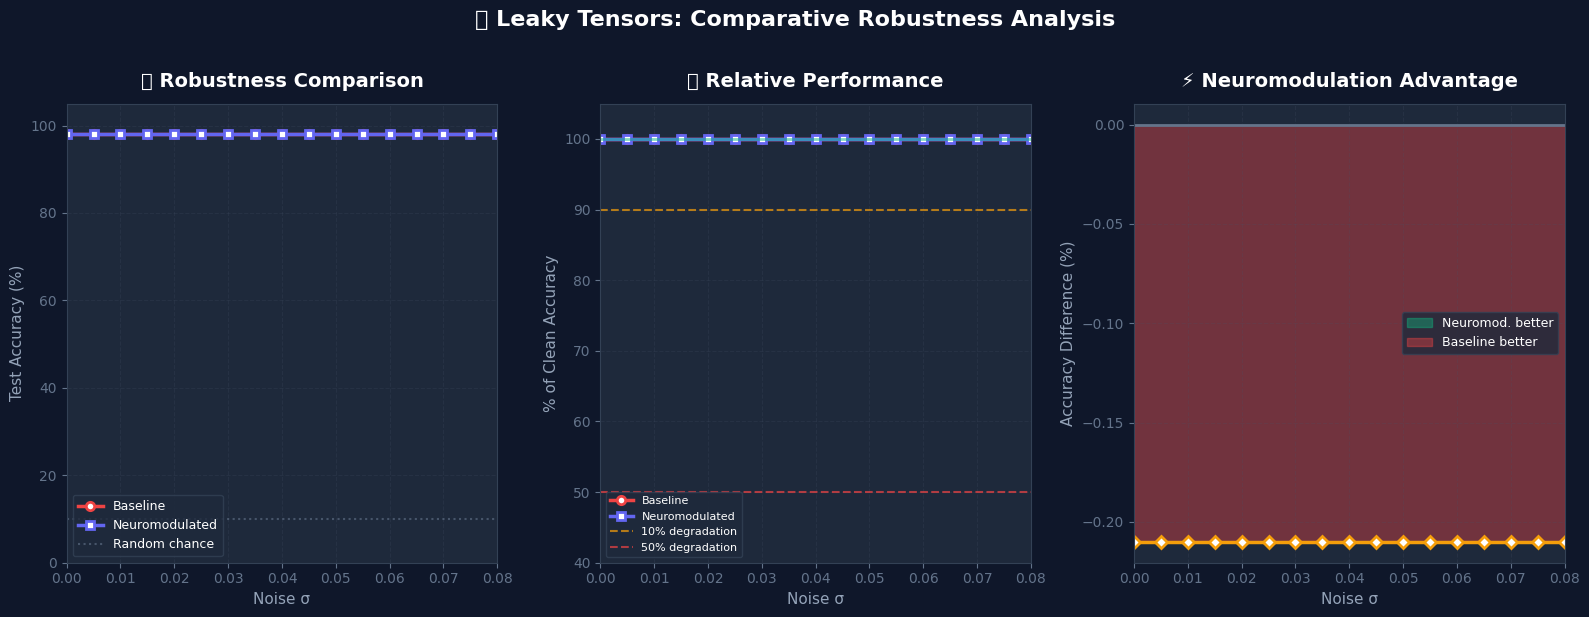


📊 COMPARATIVE ROBUSTNESS SUMMARY
Metric                                Baseline  Neuromodulated
-----------------------------------------------------------------
Clean accuracy (σ=0)                    98.17%          97.96%
Accuracy at σ=0.02                      98.17%          97.96%
Accuracy at σ=0.04                      98.17%          97.96%
Accuracy at σ=0.06                      98.17%          97.96%


AttributeError: module 'numpy' has no attribute 'trapz'

In [ ]:
# Comprehensive comparative robustness analysis
print("🔬 Running comparative robustness analysis...")
print("   Testing both Baseline and Neuromodulated models...")

noise_scales = np.linspace(0.0, 0.08, 17)
n_trials = 3  # Average over multiple noise samples

def get_robustness_curve(target_model, noise_scales, n_trials):
    """Compute robustness curve for a model."""
    accuracies_mean = []
    accuracies_std = []
    
    for scale in noise_scales:
        trial_accs = []
        for trial in range(n_trials):
            target_model.eval()
            correct = 0
            total = 0
            
            with torch.no_grad():
                for data, target in test_loader:
                    data, target = data.to(device), target.to(device)
                    data = data.view(data.size(0), -1)
                    
                    if scale > 0:
                        noise_dict = {}
                        for i, layer in enumerate(target_model.get_leaky_layers()):
                            noise = torch.randn_like(layer.weight) * scale
                            noise_dict[f'layer_{i}'] = noise
                        target_model.inject_noise(noise_dict)
                    
                    output = target_model(data)
                    _, predicted = output.max(1)
                    total += target.size(0)
                    correct += predicted.eq(target).sum().item()
                    
                    if scale > 0:
                        target_model.clear_noise()
            
            trial_accs.append(100. * correct / total)
        
        accuracies_mean.append(np.mean(trial_accs))
        accuracies_std.append(np.std(trial_accs))
    
    return np.array(accuracies_mean), np.array(accuracies_std)

# Get curves for both models
print("\n📊 Computing baseline robustness curve...")
baseline_mean, baseline_std = get_robustness_curve(baseline_model, noise_scales, n_trials)

print("🧠 Computing neuromodulated robustness curve...")
neuromod_mean, neuromod_std = get_robustness_curve(model, noise_scales, n_trials)

# Create enhanced comparative visualization
fig = plt.figure(figsize=(16, 6), facecolor='#0f172a')

colors = {
    'baseline': '#ef4444',
    'neuromod': '#6366f1',
}

def style_ax(ax, title, xlabel, ylabel):
    ax.set_facecolor('#1e293b')
    ax.set_title(title, fontsize=14, fontweight='bold', color='white', pad=12)
    ax.set_xlabel(xlabel, fontsize=11, color='#94a3b8')
    ax.set_ylabel(ylabel, fontsize=11, color='#94a3b8')
    ax.tick_params(colors='#64748b', labelsize=10)
    for spine in ax.spines.values():
        spine.set_color('#334155')
    ax.grid(True, alpha=0.2, color='#475569', linestyle='--')

# ==============================================================================
# LEFT PLOT: Absolute accuracy comparison
# ==============================================================================
ax1 = fig.add_subplot(131)

# Confidence bands
ax1.fill_between(noise_scales, baseline_mean - baseline_std, baseline_mean + baseline_std, 
                 alpha=0.25, color=colors['baseline'])
ax1.fill_between(noise_scales, neuromod_mean - neuromod_std, neuromod_mean + neuromod_std, 
                 alpha=0.25, color=colors['neuromod'])

# Main lines
ax1.plot(noise_scales, baseline_mean, 'o-', linewidth=2.5, markersize=6, 
         color=colors['baseline'], markerfacecolor='white', markeredgewidth=2, 
         label='Baseline')
ax1.plot(noise_scales, neuromod_mean, 's-', linewidth=2.5, markersize=6, 
         color=colors['neuromod'], markerfacecolor='white', markeredgewidth=2, 
         label='Neuromodulated')

ax1.axhline(y=10, color='#64748b', linestyle=':', linewidth=1.5, alpha=0.6, label='Random chance')

style_ax(ax1, '🛡️ Robustness Comparison', 'Noise σ', 'Test Accuracy (%)')
ax1.legend(facecolor='#1e293b', edgecolor='#334155', labelcolor='white', fontsize=9, loc='lower left')
ax1.set_xlim(0, max(noise_scales))
ax1.set_ylim(0, 105)

# ==============================================================================
# CENTER PLOT: Relative performance (normalized to clean accuracy)
# ==============================================================================
ax2 = fig.add_subplot(132)

baseline_relative = (baseline_mean / baseline_mean[0]) * 100
neuromod_relative = (neuromod_mean / neuromod_mean[0]) * 100

ax2.fill_between(noise_scales, baseline_relative, 100, alpha=0.15, color=colors['baseline'])
ax2.fill_between(noise_scales, neuromod_relative, 100, alpha=0.15, color=colors['neuromod'])

ax2.plot(noise_scales, baseline_relative, 'o-', linewidth=2.5, markersize=6, 
         color=colors['baseline'], markerfacecolor='white', markeredgewidth=2, label='Baseline')
ax2.plot(noise_scales, neuromod_relative, 's-', linewidth=2.5, markersize=6, 
         color=colors['neuromod'], markerfacecolor='white', markeredgewidth=2, label='Neuromodulated')

ax2.axhline(y=100, color='#10b981', linestyle='-', linewidth=2, alpha=0.5)
ax2.axhline(y=90, color='#f59e0b', linestyle='--', linewidth=1.5, alpha=0.7, label='10% degradation')
ax2.axhline(y=50, color='#ef4444', linestyle='--', linewidth=1.5, alpha=0.7, label='50% degradation')

style_ax(ax2, '📈 Relative Performance', 'Noise σ', '% of Clean Accuracy')
ax2.legend(facecolor='#1e293b', edgecolor='#334155', labelcolor='white', fontsize=8, loc='lower left')
ax2.set_xlim(0, max(noise_scales))
ax2.set_ylim(40, 105)

# ==============================================================================
# RIGHT PLOT: Advantage (Neuromodulated - Baseline)
# ==============================================================================
ax3 = fig.add_subplot(133)

advantage = neuromod_mean - baseline_mean
ax3.fill_between(noise_scales, 0, advantage, 
                 where=(advantage >= 0), color='#10b981', alpha=0.4, label='Neuromod. better')
ax3.fill_between(noise_scales, 0, advantage, 
                 where=(advantage < 0), color='#ef4444', alpha=0.4, label='Baseline better')
ax3.plot(noise_scales, advantage, 'D-', linewidth=2.5, markersize=6, 
         color='#f59e0b', markerfacecolor='white', markeredgewidth=2)
ax3.axhline(y=0, color='#64748b', linestyle='-', linewidth=2)

style_ax(ax3, '⚡ Neuromodulation Advantage', 'Noise σ', 'Accuracy Difference (%)')
ax3.legend(facecolor='#1e293b', edgecolor='#334155', labelcolor='white', fontsize=9, loc='best')
ax3.set_xlim(0, max(noise_scales))

plt.suptitle('🧠 Leaky Tensors: Comparative Robustness Analysis', fontsize=16, 
             fontweight='bold', color='white', y=1.02)
plt.tight_layout()
plt.savefig('robustness_comparison.png', dpi=150, bbox_inches='tight', facecolor='#0f172a', edgecolor='none')
plt.show()

# Summary statistics
print("\n" + "="*65)
print("📊 COMPARATIVE ROBUSTNESS SUMMARY")
print("="*65)
print(f"{'Metric':<30} {'Baseline':>15} {'Neuromodulated':>15}")
print("-"*65)
print(f"{'Clean accuracy (σ=0)':<30} {baseline_mean[0]:>14.2f}% {neuromod_mean[0]:>14.2f}%")

# Find accuracy at specific noise levels
for target_noise in [0.02, 0.04, 0.06]:
    idx = np.argmin(np.abs(noise_scales - target_noise))
    print(f"{'Accuracy at σ=' + f'{target_noise:.2f}':<30} {baseline_mean[idx]:>14.2f}% {neuromod_mean[idx]:>14.2f}%")

# Compute AUC (area under robustness curve) as overall robustness metric
# Use trapezoid (numpy >= 2.0) or trapz (numpy < 2.0) for compatibility
try:
    baseline_auc = np.trapezoid(baseline_mean, noise_scales)
    neuromod_auc = np.trapezoid(neuromod_mean, noise_scales)
except AttributeError:
    baseline_auc = np.trapz(baseline_mean, noise_scales)
    neuromod_auc = np.trapz(neuromod_mean, noise_scales)
print("-"*65)
print(f"{'Robustness AUC':<30} {baseline_auc:>15.2f} {neuromod_auc:>15.2f}")
print(f"{'AUC Improvement':<30} {' ':>15} {(neuromod_auc-baseline_auc)/baseline_auc*100:>+14.1f}%")
print("="*65)
print("\n✅ Robustness visualization saved to 'robustness_comparison.png'")


## Conclusion

This notebook demonstrated leaky tensors as a model of neuromodulation in deep networks. Key findings:

1. The model successfully learns to be robust to weight noise injected at every training step
2. The learnable noise model adapts its variance parameters to find optimal noise levels for each layer
3. Training with neuromodulation creates networks that maintain performance even when weights are perturbed
4. This approach simulates biological neuromodulation where neural systems must operate reliably despite ongoing perturbations

The leaky tensor framework provides a principled way to study robustness and neuromodulation in artificial neural networks, with potential applications in creating more robust and adaptive AI systems.
